

# XDAWN Denoising

XDAWN filters are trained from epochs, signal is projected in the sources
space and then projected back in the sensor space using only the first two
XDAWN components. The process is similar to an ICA, but is
supervised in order to maximize the signal to signal + noise ratio of the
evoked response :footcite:`RivetEtAl2009, RivetEtAl2011`.

<div class="alert alert-danger"><h4>Warning</h4><p>As this denoising method exploits the known events to
             maximize SNR of the contrast between conditions it can lead
             to overfitting. To avoid a statistical analysis problem you
             should split epochs used in fit with the ones used in
             apply method.</p></div>


In [ ]:
# Authors: Alexandre Barachant <alexandre.barachant@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [1]:
from mne import Epochs, compute_raw_covariance, io, pick_types, read_events
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image

print(__doc__)

data_path = sample.data_path()

Automatically created module for IPython interactive environment


Set parameters and read data



Opening raw data file C:\Users\ja_to\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s


Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


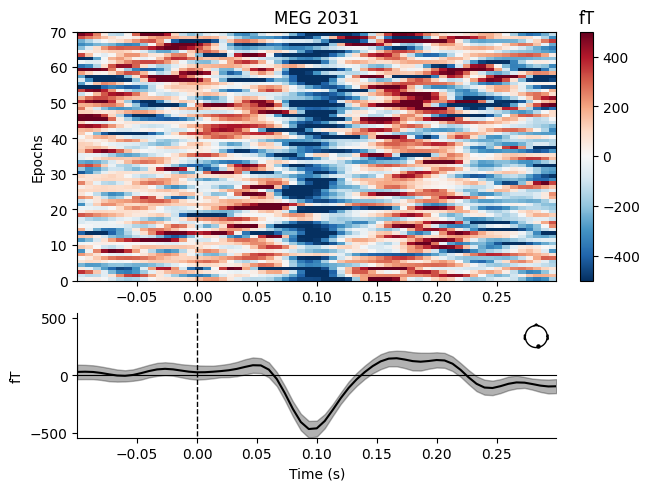

[<Figure size 640x480 with 4 Axes>]

In [2]:
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
event_fname = meg_path / "sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0.1, 0.3
event_id = dict(vis_r=4)

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 20, fir_design="firwin")  # replace baselining with high-pass
events = read_events(event_fname)

raw.info["bads"] = ["MEG 2443"]  # set bad channels
picks = pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False, exclude="bads")
# Epoching
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=False,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)

# Plot image epoch before xdawn
plot_epochs_image(epochs["vis_r"], picks=[230], vmin=-500, vmax=500)

Now, we estimate a set of xDAWN filters for the epochs (which contain only
the ``vis_r`` class).



In [3]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(raw, picks=picks)

# Xdawn instance
xd = Xdawn(n_components=2, signal_cov=signal_cov)

# Fit xdawn
xd.fit(epochs)

Using up to 1388 segments
Number of samples used : 41640
[done]
Computing rank from data with rank='full'
    MEG: rank 305 from info
    Created an SSP operator (subspace dimension = 3)
Reducing data rank from 305 -> 305
Estimating covariance using EMPIRICAL
Done.


Xdawn({'correct_overlap': 'auto',
 'n_components': 2,
 'reg': None,
 'signal_cov': {'bads': [],
                'data': array([[ 2.76034881e-23,  7.64375960e-24,  2.63823622e-25, ...,
         4.35082587e-24,  4.65725273e-24,  7.73336955e-25],
       [ 7.64375960e-24,  1.16029469e-23,  4.56738274e-27, ...,
         1.32282969e-24,  1.50679262e-24,  1.79136231e-25],
       [ 2.63823622e-25,  4.56738274e-27,  8.23806149e-26, ...,
         1.64076443e-25, -1.91948636e-25,  2.59682119e-27],
       ...,
       [ 4.35082587e-24,  1.32282969e-24,  1.64076443e-25, ...,
         4.13521268e-23,  1.62391614e-24, -2.87534722e-25],
       [ 4.65725273e-24,  1.50679262e-24, -1.91948636e-25, ...,
         1.62391614e-24,  2.91638778e-23,  4.68688776e-25],
       [ 7.73336955e-25,  1.79136231e-25,  2.59682119e-27, ...,
        -2.87534722e-25,  4.68688776e-25,  9.39973167e-26]]),
                'diag': False,
                'dim': 305,
                'eig': None,
                'eigvec': None,
  

Epochs are denoised by calling ``apply``, which by default keeps only the
signal subspace corresponding to the first ``n_components`` specified in the
``Xdawn`` constructor above.



Transforming to Xdawn space
Zeroing out 303 Xdawn components
Inverse transforming to sensor space
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


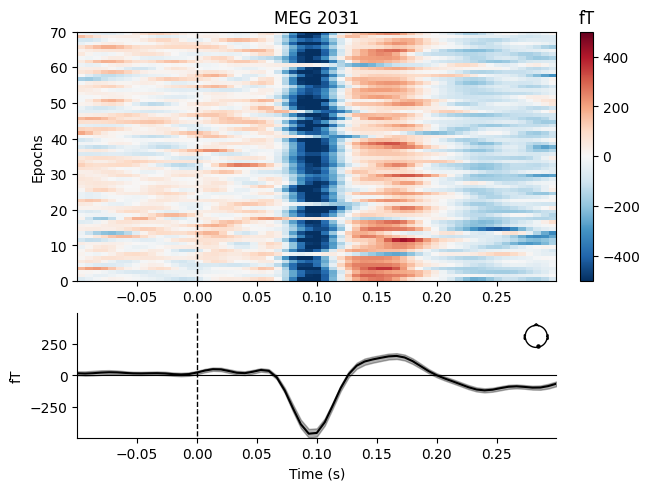

[<Figure size 640x480 with 4 Axes>]

In [4]:
epochs_denoised = xd.apply(epochs)

# Plot image epoch after Xdawn
plot_epochs_image(epochs_denoised["vis_r"], picks=[230], vmin=-500, vmax=500)

## References
.. footbibliography::

